# Bayesian Multilevel Modelling using PyStan

Folowing through Chris Fonnesbeck's [primer on using PyStan with Bayesian Multilevel Modelling](http://mc-stan.org/documentation/case-studies/radon.html).

* *Multilevel model*: a regression model in which constituent model parameters are given probability models, which implies that they can vary by group. These are generalisations of regression modelling.
* *Hierarchical model*: a multilevel model where parameters are nested within one another.

## Example: Radon contamination

Radon is a radioactive gas that enters homes through contact points with the ground. The EPA conducted a study of radon levels in 80,000 houses. There were two important predictors:

* measurement in the basement, or ground floor (radon expected to be higher in basements)
* uranium level (correlates positively with radon level)

We will model radon levels in a single state: Minnesota. The hierarchy in this example is households, which exist within counties.

### Comments

In the first instance, we have a model where output is measured radon level as a function of the floor of the house at which the radon was measured (basement or ground floor), and the prevailing radon level.

Our estimate of the parameter of prevailing radon level can be considered a *prediction* of the prevailing radon level.

The prevailing radon level may be taken to be that for the state (counties *pooled*) or that for the county (*unpooled*), or as some intermediate representation.

The model is *multilevel* because we are sampling the two parameters of prevailing radon level, and the effect of changing floor, from a probabilistic distribution.

The model is *hierarchical* because households exist within counties (which exist within the state).

We already have the model 'outputs': data for household radon level measurements, with their counties; and *inputs*: the floor level at which the measurements were taken. We are attempting to estimate the parameters for alternative formulations of the model, and to assess which model is the best explanation for the observed data/best predictor for prevailing radon level. With a good model, we could go forward to predict new radon levels, given a county and floor.

## Building the model

We first import the necessary modules:

* `pylab`: MatLab-like Python inline matrix maths and visualisation
* `numpy`: Numerical approaches in Python
* `pandas`: `R`-like dataframes in Python
* `seaborn`: prettier graphics than the `pylab` default
* `pystan`: Python implementation of Stan

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import seaborn as sns; sns.set_context('notebook')
import pystan

Populating the interactive namespace from numpy and matplotlib


### Data import and cleanup

Next we import the radon data. For cleanup, we strip whitespace from column headers, restrict data to Minnesota (`MN`) and add a unique numerical identifier for each county.

In [2]:
# Import radon data
srrs2 = pd.read_csv('data/srrs2.dat')
srrs2.columns = srrs2.columns.map(str.strip)

# Make a combined state and county ID, by household
srrs_mn = srrs2.assign(fips=srrs2.stfips * 1000 + srrs2.cntyfips)[srrs2.state == 'MN']

In [3]:
# Check data
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips
5080,5081,MN,MN,27,55735,5,1,1,3,N,...,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001
5081,5082,MN,MN,27,55748,5,1,0,4,Y,...,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001
5082,5083,MN,MN,27,55748,5,1,0,4,Y,...,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001
5083,5084,MN,MN,27,56469,5,1,0,4,Y,...,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001
5084,5085,MN,MN,27,55011,3,1,0,4,Y,...,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003


We import uranium data for each county, creating a unique identifier for each county to match that in `srrs`.

In [4]:
# Obtain the uranium level as a county-level predictor
cty = pd.read_csv('data/cty.dat')
cty_mn = cty[cty.st == 'MN'].copy()  # MN only data

# Make a combined state and county id, by county
cty_mn['fips'] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [5]:
# Check data
cty_mn.head()

,stfips,ctfips,st,cty,lon,lat,Uppm,fips
1326,27,1,MN,AITKIN,-93.415,46.608,0.502054,27001
1327,27,3,MN,ANOKA,-93.246,45.273,0.428565,27003
1328,27,5,MN,BECKER,-95.674,46.935,0.892741,27005
1329,27,7,MN,BELTRAMI,-94.937,47.974,0.552472,27007
1330,27,9,MN,BENTON,-93.998,45.699,0.866849,27009


It is convenient to bring all the data into a single dataframe with radon and uranium data byhousehold, so we merge on the basis of the unique county identifier, to assign uranium data across all households in a county.

In [6]:
# Combine data into a single dataframe
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')  # Get uranium level by household (on county basis)
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')  # Lose duplicate houses
u = np.log(srrs_mn.Uppm)  # log-transform uranium level
n = len(srrs_mn)  # number of households

In [7]:
# Check data
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


We create a dictionary associating each county with a unique index code, for use in Stan.

In [8]:
# Index counties with a lookup dictionary
srrs_mn.county = srrs_mn.county.str.strip()
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

For construction of the Stan model, it is convenient to have the relevant variables as local copies - this aids readability.

* index code for each county
* radon activity
* log radon activity
* which floor measurement was taken

In [9]:
# Make local copies of variables
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

## Modelling distribution of radon in MN

Visual inspection of the variation in (log) observed radon levels shows a broad range of values. We aim to determine the contributions of the prevailing radon level and the floor at which radon level is measured, to produce this distribution of observed values.

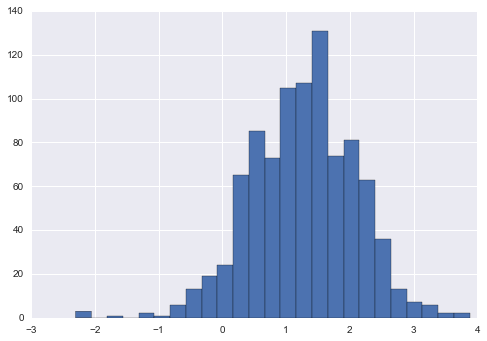

In [10]:
srrs_mn.activity.apply(lambda x: np.log(x + 0.1)).hist(bins=25);

## Conventional approaches

Two conventional alternatives to modelling, *pooling* and *not pooling* represent two extremes of a [tradeoff between variance and bias](http://scott.fortmann-roe.com/docs/BiasVariance.html).

### The bias-variance tradeoff

Where the variable we are trying to predict is $Y$, as a function of covariates $X$, we assume a relationship $Y = f(X) + \epsilon$ where the error term $\epsilon$ is distributed normally with mean zero: $\epsilon \sim N(0, \sigma_{\epsilon})$.

We estimate a *model* $\hat{f}(X)$ of $f(X)$ using some technique. This gives us squared prediction error: $\textrm{Err}(x) = E[(Y − \hat{f}(x))^2]$. That squared error can be decomposed into:

$$\textrm{Err}(x)=(E[\hat{f} (x)] − f(x))^2 + E[(\hat{f}(x) − E[\hat{f}(x)])^2] + \sigma^2_e$$

where

* $E[\hat{f} (x)] − f(x))^2$ is the square of the difference between the model $\hat{f}(x)$ and the 'true' relationship $f(x)$, i.e. the square of the *bias*
* $E[(\hat{f}(x) − E[\hat{f}(x)])^2]$ is the square of the difference between the mean behaviour of the model and the observed behaviour of this model, i.e. the square of the *variance*
* $\sigma^2_e$ is the noise of the 'true' relationship that cannot be captured in any model, i.e. the *irreducible error*

With a known true model, and an infinite amount of data, it is in principle possible to reduce both *bias* and *variance* to zero. In reality, both sources of error exist, and we choose to minimise *bias* and/or *variance*.

### The trade-off in the radon model

Taking $y = \log(\textrm{radon})$, floor measurements (basement or ground) as $x$, where $i$ indicates the house, and $j[i]$ is the county to which a house 'belongs'. Then $\alpha$ is the radon level across all counties, and $\alpha_{j[i]}$ is the radon level in a single county; $\beta$ is the influence of the choice of floor at which measurement is made; and $\epsilon$ is some other error (measurement error, temporal variation in a house, or variation among houses).

We take two approaches:

* **Complete pooling** - treat all counties the same, and estimate a single radon level: $y_i = \alpha + \beta x_i + \epsilon_i$
* **No pooling** - treat each county independently: $y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$

When we do not pool, we will likely obtain quite different parameter estimates $\alpha_{j[i]}$ for each county - especially when there are few observations in a county. As new data is gathered, these estimates are likely to change radically. This is therefore a model with *high variance*.

Alternatively, by pooling all counties, we will obtain a single estimate for $\alpha$, but this value may deviate quite far from the true situation in some or all counties. This is therefore a model with *high bias*.

So, if we treat all counties as the same, we have a biased estimate, but if we treat them as individuals, we have high variance - the *bias-variance tradeoff*. It may be the case that neither extreme produces a good model for the real behaviour: models that minimise bias to produce a high variance error are *overfit*; those that minimise variance to produce a strong bias error are *underfit*.

### Specifying the pooled model in Stan

To build a model in Stan, we need to define `data`, `parameters`, and the `model` itself. This is done by creating strings in the Stan language, rather than having an API that provides a constructor for the model.

We construct the `data` block to comprise the number of samples (`N`, `int`), with vectors of log-radon measurements (`y`, a `vector` of length `N`) and the floor measurement covariates (`x`, `vector`, length `N`).

In [11]:
# Construct the data block.
pooled_data = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
"""

Next we initialise parameters, which here are linear model coefficients (`beta`, a `vector` of length 2) that represent both $\alpha$ and $\beta$ in the pooled model definition, as `beta[1]` and `beta[2]` are assumed to lie on a Normal distribution, and the Normal distribution scale parameter `sigma` defining errors in the model's prediction of the output (`y`, defined later), which is constrained to be positive.

In [12]:
# Initialise parameters
pooled_parameters = """
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
"""

Finally we specify the model, with log(radon) measurements as a normal sample, having a mean that is a function of the choice of floor at which the measurement was made, $y \sim N(\beta[1] + \beta[2]x, \sigma_e)$

In [13]:
pooled_model = """
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

### Running the pooled model in Stan

We need to map Python variables to those in the `stan` model, and pass the data, parameters and model strings above to `stan`. We also need to specify how many iterations of sampling we want, and how many parallel chains to sample (here, 1000 iterations of 2 chains).

This is where explicitly-named local variables are convenient for definition of Stan models.

Calling `pystan.stan` doesn't just define the model, ready to fit - it runs the fitting immediately.

In [14]:
pooled_data_dict = {'N': len(log_radon),
                    'x': floor_measure,
                    'y': log_radon}

pooled_fit = pystan.stan(model_code=pooled_data + pooled_parameters + pooled_model,
                         data=pooled_data_dict,
                         iter=1000,
                         chains=2)

Once the fit has been run, the sample can be extracted for visualisation and summarisation. Specifying `permuted=True` means that all fitting chains are merged and warmup samples are discarded and that a dictionary is returned, with samples for each parameter:

In [15]:
# Collect the sample
pooled_sample = pooled_fit.extract(permuted=True)

The output is an `OrderedDict` with two keys of interest to us: `beta` and `sigma`. `sigma` describes the estimated error term, and `beta` describes the estimated values of $\alpha$ and $\beta$ for each iteration:

In [16]:
# Inspect the sample
pooled_sample['beta']

array([[ 1.32310271, -0.51966555],
       [ 1.41271557, -0.57971591],
       [ 1.33030468, -0.57546763],
       ..., 
       [ 1.40113564, -0.67468917],
       [ 1.38265747, -0.68106912],
       [ 1.39253953, -0.66235175]])

While it can be very interesting to see the results for individual iterations (and how they vary), for now we are interested in the mean values of these estimates:

In [17]:
# Get mean values for parameters, from the sample
# b0 = common radon value across counties (alpha)
# m0 = variation in radon level with change in floor (beta)
b0, m0 = pooled_sample['beta'].T.mean(1)

In [18]:
# What are the fitted parameters
print("alpha: {0}, beta: {1}".format(b0, m0))

alpha: 1.3635778734609862, beta: -0.5920500794224072


We can visualise how well this pooled model fits the observed data:

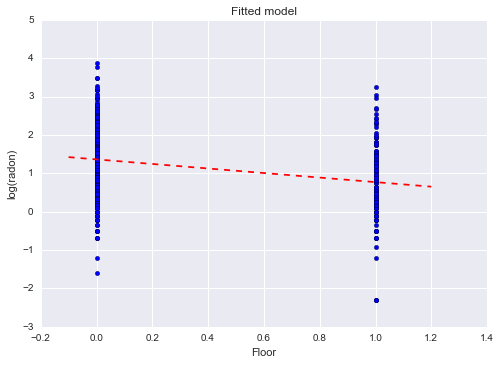

In [19]:
# Plot the fitted model (red line) against observed values (blue points)
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity + 0.1))
xvals = np.linspace(-0.1, 1.2)
plt.plot(xvals, m0 * xvals + b0, 'r--')
plt.title("Fitted model")
plt.xlabel("Floor")
plt.ylabel("log(radon)");

The answer is: not terribly badly (the fitted line runs convincingly through the centre of the data, and plausibly describes the trend), but not terribly well, either. The observed points vary widely about the fitted model, implying that the prevailing radon level varies quite widely, and we might expect different gradients if we chose different subsets of the data.

The main error in this model fit is due to *bias*, because the pooling approach is an an inaccurate representation of the underlying radon level, taken across all measurements.

### Specifying the unpooled model in Stan

For the unpooled model, we have the parameter $\alpha_{j[i]}$, representing a list of (independent) mean values, one for each county. Otherwise the model is the same as for the pooled example, with shared parameters for the effect of which floor is being measured, and the standard deviation of the error.

We construct the `data`, `parameters` and `model` blocks in a similar way to before. We define the number of samples (`N`, `int`), and two vectors of log-radon measurements (`y`, length `N`) and floor measurement covariates (`x`, length `N`). The main difference to before is that we define a list of counties (these are the indices 1..85 defined above, rather than county names), one for each sample:

In [20]:
unpooled_data = """
data {
  int<lower=0> N;
  int<lower=1, upper=85> county[N];
  vector[N] x;
  vector[N] y;
}
"""

We define three parameters: $\alpha_{j[i]}$ - one radon level per county (`a` - as a vector of length 85, one value per county); change in radon level by floor, $\beta$ (`beta`, a real value), and the Normal distribution scale parameter `sigma`, as before:

In [21]:
unpooled_parameters = """
parameters {
  vector[85] a;
  real beta;
  real<lower=0, upper=100> sigma;
}
"""

We also define transformed parameters, for convenience. This defines a new variable $\hat{y}$ (`y_hat`, a `vector` with one value per sample) which is our estimate/prediction of log(radon) value per household. This could equally well be done in the model block - we don't *need* to generate a transformed parameter, but for more complex models this is a useful technique to improve readability and maintainability.

In [22]:
unpooled_transformed_parameters = """
transformed parameters {
  vector[N] y_hat;
  
  for (i in 1:N)
    y_hat[i] <- beta * x[i] + a[county[i]];
}
"""

Using this transformed parameter, the model form is now $y \sim N(\hat{y}, \sigma_e)$, making explicit that we are fitting parameters that result in the model *predicting* a household radon measurement, and we are estimating the error of this prediction against the observed values:

In [23]:
unpooled_model = """
model {
  y ~ normal(y_hat, sigma);
}
"""

### Running the unpooled model in Stan

We again map Python variables to those used in the `stan` model, then pass the data, parameters (transformed and untransformed) and the model to `stan`. We again specify 1000 iterations of 2 chains.

Note that we have to offset our Python indices for counties by 1, as Python counts from zero, but Stan counts from 1.

In [24]:
# Map data
unpooled_data_dict = {'N': len(log_radon),
                      'county': county + 1,  # Stan counts start from 1
                      'x': floor_measure,
                      'y': log_radon}

# Fit model
unpooled_fit = pystan.stan(model_code=unpooled_data + unpooled_parameters +
                                       unpooled_transformed_parameters + unpooled_model,
                            data=unpooled_data_dict,
                            iter=1000,
                            chains=2)

We can extract the sample from the fit for visualisation and summarisation. This time we do not use the `permuted=True` option. This returns a `StanFit4Model` object, from which we can extract the fitted estimates for a parameter using indexing, like a dictionary, e.g. `unpooled_fit['beta']`, and this will return a `numpy` `ndarray` of values. For $\alpha$ (`a`) we get a 1000x85 array, for $\beta$ (`beta`) we get a 1000x1 array. Mean and standard deviation (and other summary statistics) can be calculated from these.

When extracting vectors of $\alpha_{j[i]}$ (radon levels per county) and the associated standard errors, we use a `pd.Series` object, for compatibility with `pandas`. This allows us to specify an index, which is the list of county names in `mn_counties`.

In [25]:
# Extract fit of radon by county
unpooled_estimates = pd.Series(unpooled_fit['a'].mean(0), index=mn_counties)
unpooled_se = pd.Series(unpooled_fit['a'].std(0), index=mn_counties)

In [26]:
# Inspect estimates
unpooled_estimates.head()

AITKIN      0.892922
ANOKA       0.932580
BECKER      1.546355
BELTRAMI    1.593458
BENTON      1.436562
dtype: float64

To inspect the variation in predicted radon levels at county resolution, we can plot the mean of each estimate with its associated standard error. To structure this visually, we'll reorder the counties such that we plot counties from lowest to highest.

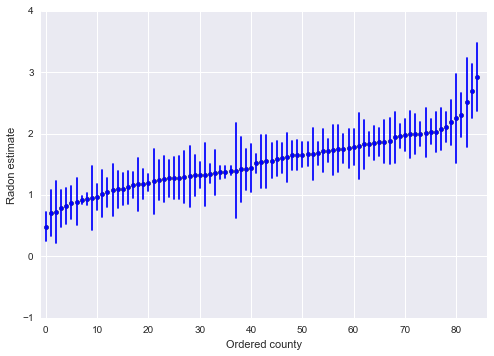

In [27]:
# Get row order of estimates as an index: low to high radon
order = unpooled_estimates.sort_values().index

# Plot mean radon estimates with stderr, following low to high radon order
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)),
                    unpooled_estimates[order],
                    unpooled_se[order]):
    plt.plot([i,i], [m - se, m + se], 'b-')
plt.xlim(-1, 86)
plt.ylim(-1, 4)
plt.xlabel('Ordered county')
plt.ylabel('Radon estimate');

From this visual inspection, we can see that there is one county with a relatively low predicted radon level, and about five with relatively high levels. This reinforces our suggestion that a pooled estimate is likely to exhibit significant *bias*.

### Plot comparison of pooled and unpooled estimates

We can make direct visual comparisons between pooled and unpooled estimates for all counties, but here we do so for a specific subset:

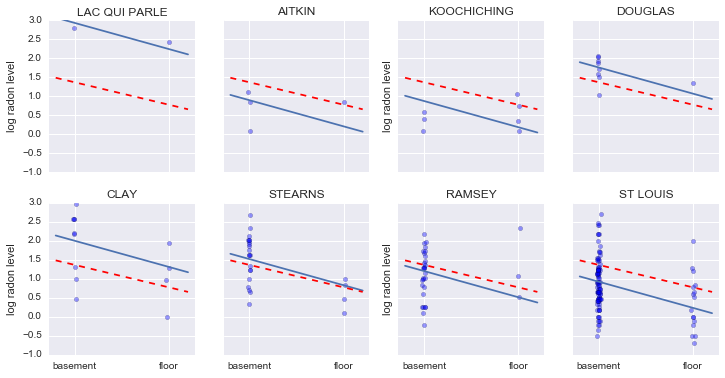

In [28]:
# Define subset of counties
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING',
                   'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY',
                   'ST LOUIS')

# Make plot
fig, axes = plt.subplots(2, 4, figsize=(12, 6),
                         sharex=True, sharey=True)
axes = axes.ravel()  # turn axes into a flattened array
m = unpooled_fit['beta'].mean(0)
for i, c in enumerate(sample_counties):
    # Get unpooled estimates and set common x values
    b = unpooled_estimates[c]
    xvals = np.linspace(-0.2, 1.2)
    
    # Plot household data
    x = srrs_mn.floor[srrs_mn.county == c]
    y = srrs_mn.log_radon[srrs_mn.county == c]
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)
    
    # Plot models
    axes[i].plot(xvals, m * xvals + b)  # unpooled
    axes[i].plot(xvals, m0 * xvals + b0, 'r--')  # pooled
    
    # Add labels and ticks
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel('log radon level')

By visual inspection, we can see that using unpooled county estimates for prevailing radon level has resulted in models that deviate from the pooled estimates, correcting for its *bias*. However, we can also see that for counties with few observations, the fitted estimates track the observations very closely, suggesting that there has been *overfitting*. The attempt to minimise error due to *bias* has resulted in the introduction of greater error due to *variance* in the dataset.

### Conclusion

Neither model does perfectly:

* For identification of counties with a predicted prevailing high radon level, pooling is useless (because all counties are modelled with the same level)
* However, we ought not to trust any unpooled estimates that were produced using few observations on a county

Ideally, we would have an intermediate form of model that optimally minimises the errors due to both *bias* and *variance*.

## Pooling and Multilevel/Hierarchical Models

### pooled model

When we *pool* data, we imply that they are sampled from the same model. This ignores all variation (other than sampling variation) among the units being sampled. That is to say, observations $y_1, y_2, \ldots, y_k$ share common parameter(s) $\theta$:

![pooled model](images/pooled_model.png)

### unpooled model

If we analyse our data with an *unpooled* model, we separate our data out into groups (which may be as extreme as one group per sample), which implies that the groups are sampled independently from separate models because the differences between sampling units are too great for them to be reasonably combined. That is to say, observations (or grouped observations) $y_1, y_2, \ldots, y_k$ have independent parameters $\theta_1, \theta_2, \ldots, \theta_k$.

![unpooled model](images/unpooled_model.png)

### partial pooling/hierarchical modelling

In a *hierarchical*, or *partial pooling* model, model parameters are instead viewed as a sample from a population distribution of parameters, so the unpooled model parameters $\theta_1, \theta_2, \ldots, \theta_k$ can be sampled from a single distribution $N(\mu, \sigma^2)$.

![partial pooled model](images/partial_pooled_model.png)

One of the great advantages of Bayesian modelling (as opposed to linear regression modelling) is the relative ease with which one can specify multilevel models and fit them using Hamiltonian Monte Carlo.

## Partial Pooling

### A simple model

The simplest possible partial pooling model for the radon dataset is one that estimates radon levels, with no other predictors (i.e. ignoring the effect of floor). This is a compromise between pooled (mean of all counties) and unpooled (county-level means), and approximates a *weighted average* (by sample size) of unpooled county means, and the pooled mean:

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

* $\hat{\alpha}$ - partially-pooled estimate of radon level
* $n_j$ - number of samples in county $j$
* $\bar{y}_j$ - estimated mean for county $j$
* $\sigma_y^2$ - s.e. of $\bar{y}_j$, variability of the county mean
* $\bar{y}$ - pooled mean estimate for $\alpha$
* $\sigma_{\alpha}^2$ - s.e. of $\bar{y}$